In [78]:
import numpy as np
import matplotlib as plt
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM



In [79]:
df = pd.read_csv("../data/Summer-Olympic-medals-1976-to-2008.csv", encoding='ISO-8859-1')


In [80]:
df.shape

(15433, 11)

In [81]:
null_counts = df.isnull().sum()
print(null_counts)

City            117
Year            117
Sport           117
Discipline      117
Event           117
Athlete         117
Gender          117
Country_Code    117
Country         117
Event_gender    117
Medal           117
dtype: int64


In [82]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15433 entries, 0 to 15432
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          15316 non-null  object 
 1   Year          15316 non-null  float64
 2   Sport         15316 non-null  object 
 3   Discipline    15316 non-null  object 
 4   Event         15316 non-null  object 
 5   Athlete       15316 non-null  object 
 6   Gender        15316 non-null  object 
 7   Country_Code  15316 non-null  object 
 8   Country       15316 non-null  object 
 9   Event_gender  15316 non-null  object 
 10  Medal         15316 non-null  object 
dtypes: float64(1), object(10)
memory usage: 1.3+ MB


In [83]:
null_columns = df.columns[df.isnull().any()]
print(null_columns)

Index(['City', 'Year', 'Sport', 'Discipline', 'Event', 'Athlete', 'Gender',
       'Country_Code', 'Country', 'Event_gender', 'Medal'],
      dtype='object')


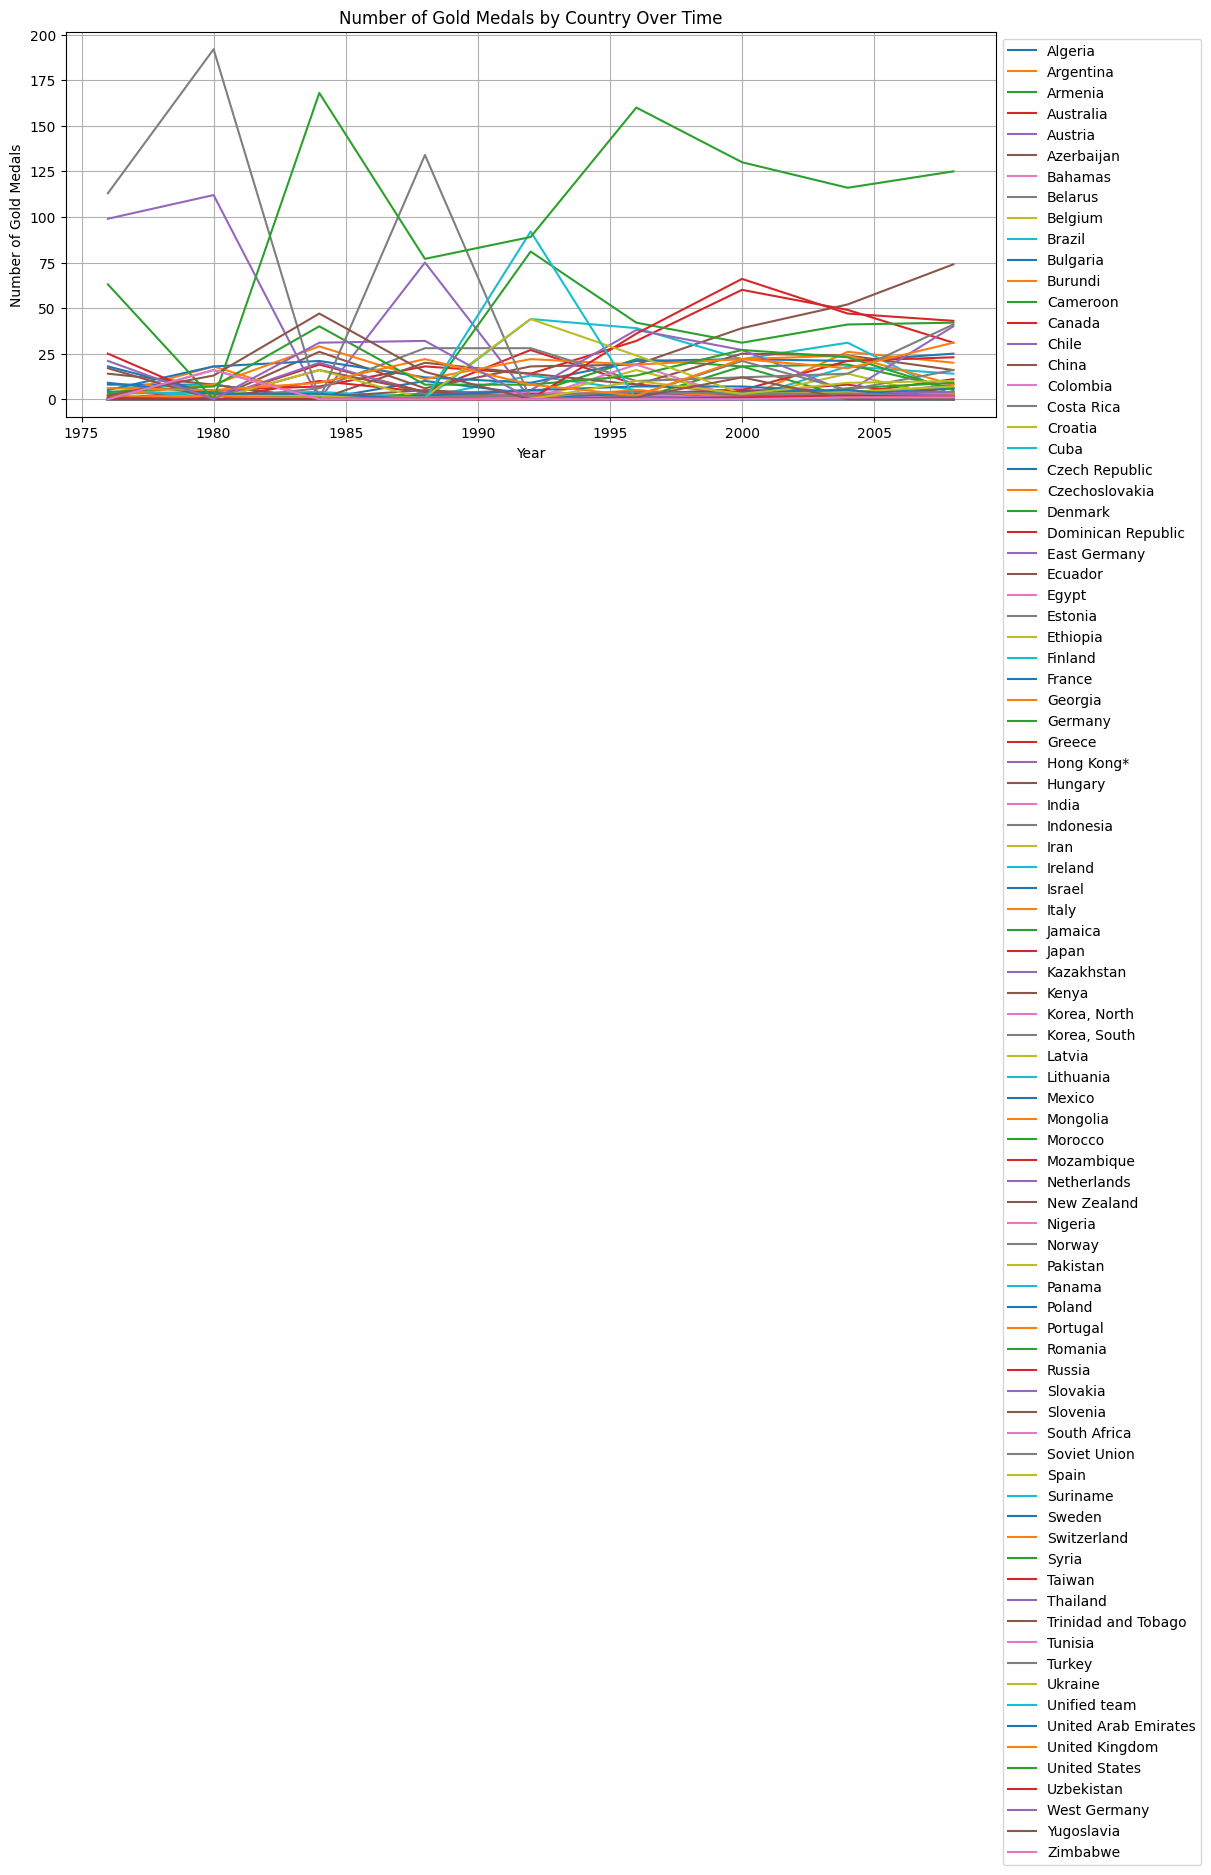

In [84]:
# Step 1: Filter the DataFrame to include only gold medals
gold_medals = df[df['Medal'] == 'Gold']

# Step 2: Group by 'Country' and 'Year', then count the number of medals
gold_medal_counts = gold_medals.groupby(['Country', 'Year']).size().unstack(fill_value=0)

# Step 3: Plot the line chart
plt.figure(figsize=(12, 5))
for country in gold_medal_counts.index:
    plt.plot(gold_medal_counts.columns, gold_medal_counts.loc[country], label=country)

plt.xlabel('Year')
plt.ylabel('Number of Gold Medals')
plt.title('Number of Gold Medals by Country Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.grid(True)
plt.show()

In [85]:
# Group by Country and Year to get the total number of medals each country won each year
country_medal_counts = df.groupby(['Country', 'Year']).size().unstack(fill_value=0)


print(country_medal_counts)


Year             1976.0  1980.0  1984.0  1988.0  1992.0  1996.0  2000.0  \
Country                                                                   
Afghanistan           0       0       0       0       0       0       0   
Algeria               0       0       2       0       2       3       5   
Argentina             0       0       0      13       2      20      20   
Armenia               0       0       0       0       0       2       1   
Australia            24      12      50      34      57     132     183   
...                 ...     ...     ...     ...     ...     ...     ...   
Virgin Islands*       0       0       0       1       0       0       0   
West Germany         75       0     157     113       0       0       0   
Yugoslavia           19      57      87      63       0      26      26   
Zambia                0       0       1       0       0       1       0   
Zimbabwe              0      16       0       0       0       0       0   

Year             2004.0 

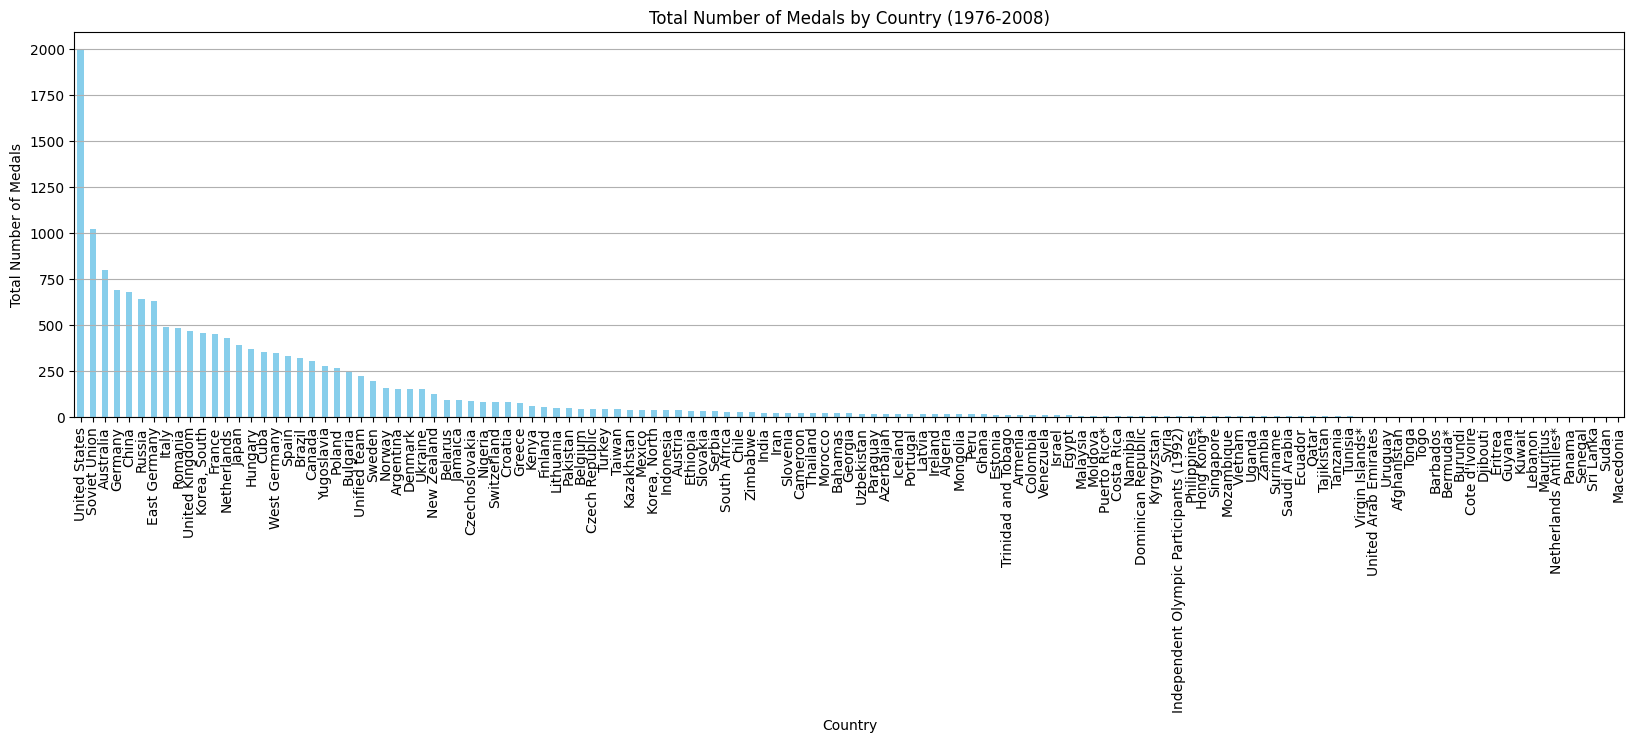

In [86]:
total_medals_by_country = df.groupby('Country').size()

total_medals_by_country = total_medals_by_country.sort_values(ascending=False)

plt.figure(figsize=(20, 5))
total_medals_by_country.plot(kind='bar', color='skyblue')

plt.xlabel('Country')
plt.ylabel('Total Number of Medals')
plt.title('Total Number of Medals by Country (1976-2008)')
plt.xticks(rotation=90)  
plt.grid(axis='y')

# Show the plot
plt.show()

In [87]:
cutoff_year = 1996


In [160]:
# Prepare the data for a specific country, e.g., 'USA'
country = "United States"
country_data = df[df['Country'] == country].groupby('Year').size().reset_index(name='y')
country_data.columns = ['ds', 'y']
country_data['ds'] = pd.to_datetime(country_data['ds'], format='%Y')
print(country_data)



          ds    y
0 1976-01-01  155
1 1984-01-01  333
2 1988-01-01  193
3 1992-01-01  224
4 1996-01-01  260
5 2000-01-01  248
6 2004-01-01  264
7 2008-01-01  315


In [161]:
# Split the data into training and testing sets
train_data = country_data[country_data['ds'].dt.year <= cutoff_year]
test_data = country_data[country_data['ds'].dt.year > cutoff_year]

In [162]:
print(train_data.shape)
print(train_data.head())

(5, 2)
          ds    y
0 1976-01-01  155
1 1984-01-01  333
2 1988-01-01  193
3 1992-01-01  224
4 1996-01-01  260


In [163]:
if not train_data.empty:
    # Initialize and fit the model
    model = Prophet(yearly_seasonality=True)
    model.fit(train_data)

    # Proceed with forecasting
else:
    print("Insufficient data for the selected country and cutoff year.")

17:24:06 - cmdstanpy - INFO - Chain [1] start processing
17:24:06 - cmdstanpy - INFO - Chain [1] done processing


In [164]:
# Define the future period for which you want to make predictions (e.g., next 5 Olympics)
future_years = 5
future = model.make_future_dataframe(periods=future_years * 4, freq='Y')  # Assuming Olympics every 4 years

# Make predictions
forecast = model.predict(future)

c:\Users\armuj\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [165]:
# Merge the actual and predicted data for comparison
comparison = pd.merge(test_data, forecast[['ds', 'yhat']], how='left', on='ds')

# Display the comparison
print(comparison)

          ds    y  yhat
0 2000-01-01  248   NaN
1 2004-01-01  264   NaN
2 2008-01-01  315   NaN


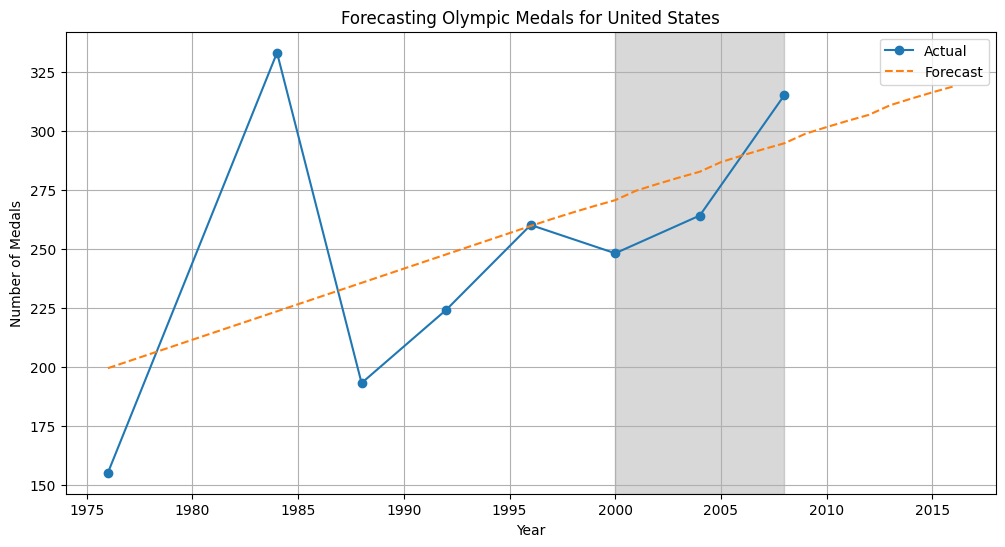

In [166]:
# Plot the predictions along with the actual data
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(country_data['ds'], country_data['y'], label='Actual', marker='o')

# Plot forecast
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')

# Highlight the test period
plt.axvspan(test_data['ds'].min(), test_data['ds'].max(), color='gray', alpha=0.3)

plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.title(f'Forecasting Olympic Medals for {country}')
plt.legend()
plt.grid(True)
plt.show()

In [167]:
# Predict medals for the next Olympics
future_medals = model.predict(future)

# Extract relevant predictions
future_medals = future_medals[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the forecasted medals
print(future_medals.tail(future_years))

           ds        yhat  yhat_lower  yhat_upper
20 2011-12-31  306.669658  236.541384  378.499506
21 2012-12-31  310.725991  238.128033  386.973941
22 2013-12-31  313.529428  242.495296  388.055897
23 2014-12-31  316.194710  240.030491  388.866751
24 2015-12-31  318.722260  241.778552  389.261208


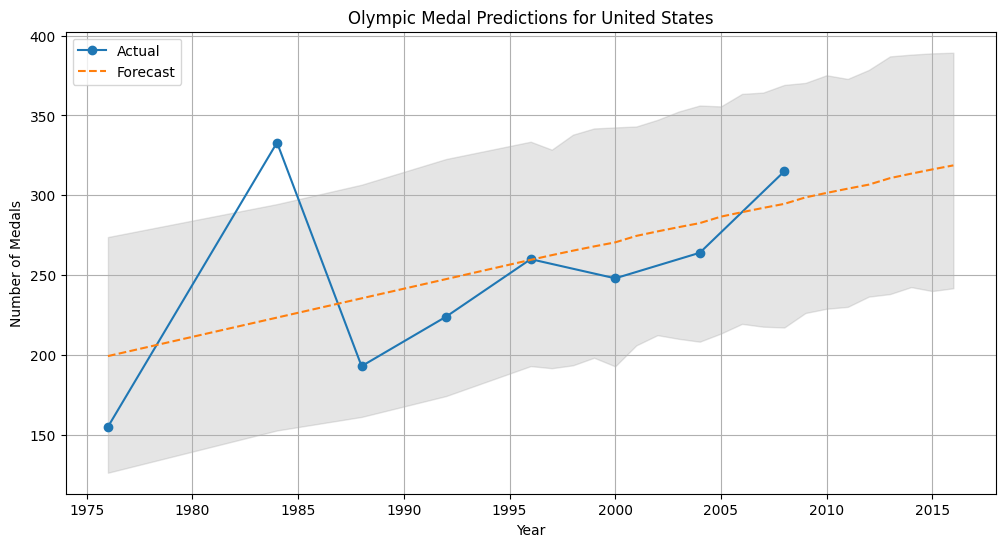

In [168]:
plt.figure(figsize=(12, 6))

# Plot actual historical data
plt.plot(country_data['ds'], country_data['y'], label='Actual', marker='o')

# Plot forecasted data
plt.plot(future_medals['ds'], future_medals['yhat'], label='Forecast', linestyle='--')

# Add uncertainty intervals to the forecast
plt.fill_between(future_medals['ds'], future_medals['yhat_lower'], future_medals['yhat_upper'], color='gray', alpha=0.2)

plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.title(f'Olympic Medal Predictions for {country}')
plt.legend()
plt.grid(True)
plt.show()

In [184]:
import pickle

# Save the model
with open('prophet_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)